<a href="https://www.kaggle.com/code/arjav007/chest-x-ray-classification?scriptVersionId=240362266" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **EDA and Data Loading**

In [2]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
from tqdm import tqdm
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## *Load Images and Labels*

The dataset used in this work is derived from images available on the [IN-CXR](https://nirt.res.in/html/xray.html) website. It has been curated to offer a processed and easily accessible collection of images specifically intended for training and evaluating CNNs and other vision models.

The **`datasets`** module from **`torchvision`** provides a convenient utility called **`ImageFolder`** for loading image data that is organized in a specific directory structure:

**root/dog/xxx.png \
root/dog/xxy.png \
root/dog/[...]/xxz.png \
.
.
. \
root/cat/123.png \
root/cat/nsdf3.png \
root/cat/[...]/asd932_.png**



In this format, each subdirectory (e.g., `dog`, `cat`) represents a separate class, and all images within that folder are automatically associated with the corresponding class label.

We will use **`ImageFolder`** to load our dataset, as it automatically maps each image to its appropriate label based on the folder name.

For our task:
- **`1` → AbNormal**
- **`0` → Normal**

This makes dataset loading both efficient and intuitive for classification tasks.


In [3]:
# Define the root directory
root = "/kaggle/input/in-cxr-dataset-png/IN-CXR (pre-processed)"

# Define data transformations (modify as needed)
transform = transforms.Compose([
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load the dataset
dataset = datasets.ImageFolder(root, transform=transform)

## *Split data for train val and test dataset*

In [5]:
# Define split ratios
train_ratio, val_ratio, test_ratio = 0.8, 0.1, 0.1  # 80% train, 10% val, 10% test
total_size = len(dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Print dataset sizes
print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")

Train size: 10080, Validation size: 1260, Test size: 1260


## *Display sample images from training dataset*

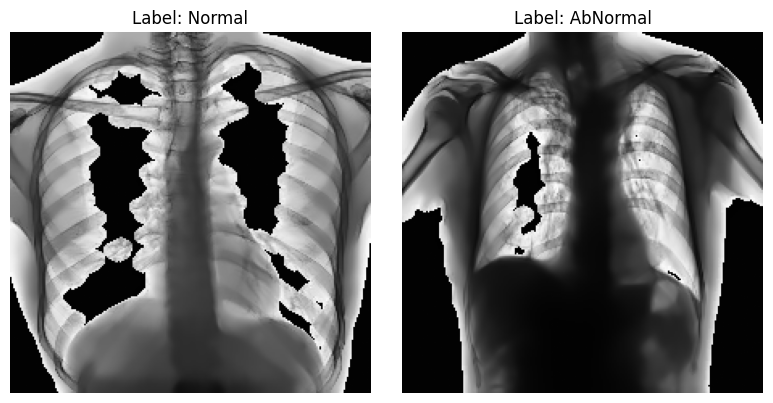

In [6]:
# Function to denormalize and convert tensor to numpy image
def denormalize(img_tensor, mean=0.5, std=0.5):
    img = img_tensor.numpy().transpose((1, 2, 0))  # (C, H, W) → (H, W, C)
    img = img * std + mean
    return np.clip(img, 0, 1)

# Find one Normal and one AbNormal image
normal_img = None
abnormal_img = None
for img_tensor, label in train_dataset:
    if label == 1 and normal_img is None:
        normal_img = (img_tensor, label)
    elif label == 0 and abnormal_img is None:
        abnormal_img = (img_tensor, label)
    if normal_img and abnormal_img:
        break

# Prepare images and labels
images = [normal_img[0], abnormal_img[0]]
labels = [normal_img[1], abnormal_img[1]]
class_names = dataset.classes  # ['AbNormal', 'Normal']

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for i in range(2):
    img = denormalize(images[i])
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].set_title(f"Label: {class_names[labels[i]]}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

## *Display Training Image distribution: TB positive and negative*

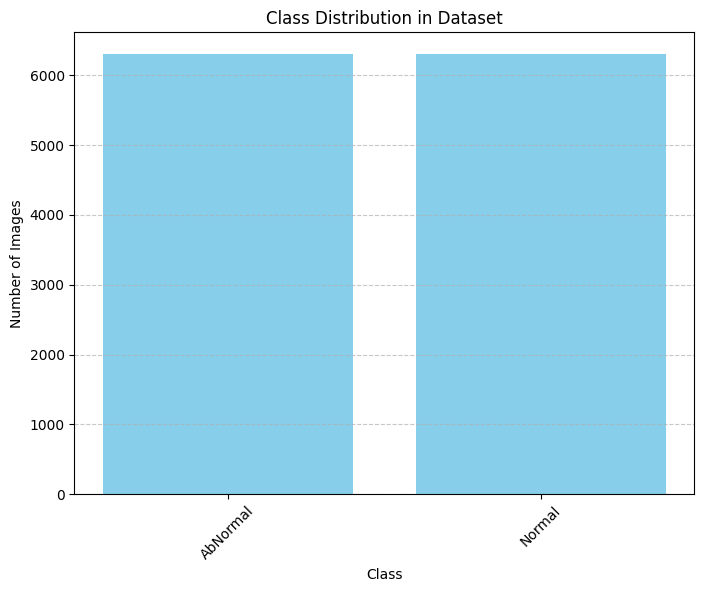

Percent of Normal images : 50.00 %
Percent of Abnormal images : 50.00 %


In [7]:
# Count the number of samples per class
class_counts = Counter([label for _, label in dataset.samples])

# Get class names and counts
class_names = dataset.classes  # Class names from ImageFolder
counts = [class_counts[i] for i in range(len(class_names))]

# Plot the class distribution
plt.figure(figsize=(8, 6))
plt.bar(class_names, counts, color='skyblue')
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Dataset")
plt.xticks(rotation=45)  # Rotate labels if needed
plt.grid(axis='y', linestyle="--", alpha=0.7)
plt.show()

abnormal_images = counts[0]
normal_images = counts[1]
print('Percent of Normal images : {:.2f} %'.format(100 * normal_images/(normal_images+abnormal_images)))
print('Percent of Abnormal images : {:.2f} %'.format(100 * abnormal_images/(normal_images+abnormal_images)))

# Training the Model

*We will be using gradient accumulation to make the training more robust and faster. It helps in simulating the larger batch sizes while handling the memory contraints. More information can be found [here](https://kozodoi.me/blog/20210219/gradient-accumulation)*

In [8]:
# Hyperparameters
EPOCHS = 7
LR = 1e-5
BATCH_SIZE = 128
MAX_PHYSICAL_BATCH_SIZE = 16
ACCUM_ITER = BATCH_SIZE // MAX_PHYSICAL_BATCH_SIZE

## *Creating the data loaders*

Since gradient accumulation will be used during training, the batch size specified in the training data loader should be less than or equal to the maximum batch size that the GPU can handle in a single forward and backward pass. This ensures that memory constraints are respected while still allowing us to simulate larger effective batch sizes through accumulation over multiple steps.

In [9]:
train_loader = DataLoader(train_dataset, batch_size = MAX_PHYSICAL_BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = MAX_PHYSICAL_BATCH_SIZE, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = MAX_PHYSICAL_BATCH_SIZE, shuffle = False)

## *Define Training Function*

In [10]:
def train(model, train_loader, val_loader, optimizer, epoch, device, accum_iter):
    model.train()
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    train_top1_acc = []
    
    optimizer.zero_grad()

    for i, (images, target) in enumerate(train_loader):   
        images = images.to(device)
        target = target.to(device)

        with torch.set_grad_enabled(True):
            # compute output
            output = model(images)
            loss = criterion(output, target)

            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            labels = target.detach().cpu().numpy()

            # measure accuracy and record loss
            acc = accuracy_score(labels, preds)
            train_losses.append(loss.item())
            train_top1_acc.append(acc)

            # gradient accumulation
            loss = loss / accum_iter
            loss.backward()

            if (i + 1) % accum_iter == 0 or (i + 1 == len(train_loader)):
                optimizer.step()
                optimizer.zero_grad()

    # Validation step
    model.eval()
    val_losses = []
    val_top1_acc = []
    
    with torch.no_grad():
        for images, target in val_loader:
            images = images.to(device)
            target = target.to(device)

            output = model(images)
            loss = criterion(output, target)

            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            labels = target.detach().cpu().numpy()

            acc = accuracy_score(labels, preds)
            val_losses.append(loss.item())
            val_top1_acc.append(acc)

    print(
        f"Epoch {epoch} Summary:\n"
        f"Train Loss: {np.mean(train_losses):.6f}, Train Acc@1: {np.mean(train_top1_acc) * 100:.2f}%\n"
        f"Val Loss:   {np.mean(val_losses):.6f}, Val Acc@1:   {np.mean(val_top1_acc) * 100:.2f}%"
    )


## *Define Evaluation Function*

In [11]:
def test(model, test_loader, device, num_classes=2):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    losses = []
    top1_acc = []
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, target in test_loader:
            images = images.to(device)
            target = target.to(device)

            output = model(images)
            loss = criterion(output, target)
            probs = torch.softmax(output, dim=1).cpu().numpy()
            preds = np.argmax(probs, axis=1)
            labels = target.cpu().numpy()

            acc = accuracy_score(labels, preds)
            losses.append(loss.item())
            top1_acc.append(acc)
            all_preds.extend(preds)
            all_labels.extend(labels)
            all_probs.extend(probs)

    top1_avg = np.mean(top1_acc)
    mean_loss = np.mean(losses)
    f1 = f1_score(all_labels, all_preds, average="macro")
    auc = roc_auc_score(all_labels, all_probs, multi_class="ovr") if num_classes > 2 else roc_auc_score(all_labels, [p[1] for p in all_probs])

    return top1_avg, f1, auc, all_labels, all_probs, mean_loss

## *Training Loop*

In [12]:
name = 'DenseNet169'
print(f"The Model is: {name}")

# Call the model
model = models.densenet169(num_classes=2)
model = model.to(device)

# Call the optimizer
optimizer = optim.AdamW(model.parameters(), lr=LR)

# Training the model
for epoch in range(EPOCHS):
    train(model, train_loader, val_loader, optimizer, epoch + 1, device, ACCUM_ITER)
    print(f"-------------------------------------")

The Model is: DenseNet169


KeyboardInterrupt: 

# **Evaluating the Model on Test Data**

To assess the model’s performance on unseen data, we use three important evaluation metrics:

1. **Accuracy –** Measures the overall correctness of the model by calculating the proportion of total predictions that were correct.
2. **F1 Score –** Provides a balance between precision and recall, especially useful when dealing with imbalanced datasets, as it considers both false positives and false negatives.
3. **AUC-ROC Score –** Evaluates the model’s ability to distinguish between classes by measuring the trade-off between the true positive rate and the false positive rate across different threshold values.

Together, these metrics offer a comprehensive view of the model’s effectiveness in handling the classification task.

In [ ]:
# Evaluating the model
top1_avg, f1, auc_score, all_labels, all_probs, mean_loss = test(model, test_loader, device)
print(
        f" Test set:"
        f" Loss: {mean_loss:.6f} "
        f" Acc: {top1_avg * 100:.6f} "
        f" F1: {f1:.6f} "
        f" AUC: {auc_score:.6f} "
    )
print(f"-------------------------------------")

# Plot ROC Curve for this batch size
plt.figure(figsize=(10, 8))
fpr, tpr, _ = roc_curve(all_labels, [p[1] for p in all_probs])  
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title(f"AUC ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

---

# **Conclusion**

This notebook demonstrated a deep learning-based approach to classify chest X-ray images for Tuberculosis (TB) detection. By leveraging Convolutional Neural Networks and appropriate evaluation metrics, we were able to build an effective model that can aid in the early and automated diagnosis of TB.

While the model demonstrates strong performance and is well-suited for the task at hand, there's always room for further improvement. There are several strategies that could be explored to further enhance its effectiveness:

1. **Reduce the Batch Size** – A smaller batch size might help the model generalize better by introducing more gradient noise during training, which can lead to improved performance on unseen data.
2. **Increase the Number of Epochs with a Learning Rate Scheduler** – Training the model for more epochs while using a learning rate scheduler can allow it to learn more thoroughly without overfitting, by gradually reducing the learning rate as training progresses.
3. **Experiment with Larger Models** – Trying architectures with more parameters and deeper layers could potentially improve performance, especially if the task benefits from higher model capacity.
4. **Perform Hyperparameter Tuning** – Systematically optimizing hyperparameters (like learning rate, dropout rate, and optimizer settings) could lead to better model performance by finding the most effective configuration

Automating lung desease detection using Deep Learning not only supports radiologists but also has the potential to make healthcare more accessible and scalable—especially in resource-limited settings.

**Thank you for exploring this notebook!**
